# Imagenet

Notebook created in PyTorch by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) for the UPC School (2020).

For this and many of the following labs we will use [Torchvision](https://pytorch.org/docs/stable/torchvision/index.html), a library with computer vision datasets, pretrained models and useful methods made to work with PyTorch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import shutil
from matplotlib.pyplot import imshow
if not torch.cuda.is_available():
    raise RuntimeError("You should enable GPU runtime!!")
device = torch.device("cuda")
torch.set_grad_enabled(True)
%matplotlib inline

# Training on Imagenet

Since Imagenet is a really big dataset, we cannot train a model on it (it would take too much time in a single GPU). Anyway, we can take a look at how this training is done in PyTorch. We will go through a very similar version to the official code that was used to train the models from [Torchvision](https://pytorch.org/docs/stable/torchvision/index.html). The code of this notebook can also serve as a template for training your own models.

## Utils

First, we will define some useful functions. Make sure you understand what they do and how they work.

In [ ]:
def adjust_learning_rate(optimizer, epoch, original_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = original_lr * (0.1 ** (epoch // 30))
    # For some models, different parameters are in different groups with different lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res  # res is a list of all the top k accuracies

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    
    # save an extra copy if it is the best model yet
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')  

## Model and optimizer

Here we will define the model. In our case, we will just take a predifined architecture from `torchvision.models`. You can take a look at the available models in: https://pytorch.org/docs/stable/torchvision/models.html

### Exercise 1

Set up the model and optimizer. Take a ResNet34 from `torchvision.models` with 100 classes (we will not train on the full ImageNet) and make sure it is on GPU. Then, declare an Adam optimizer with learning rate 0.001. You should also define the loss function for classification. The input of the loss will be the raw, unnormalized scores for each class.

In [ ]:
model = models.resnet34(pretrained=False, num_classes=100).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

try:
    assert isinstance(model, models.ResNet)
except AssertionError:
    raise Exception("Did you get an instance of a resnet34?")

try:
    assert model.fc.weight.shape[0] == 100
except AssertionError:
    raise Exception("Did you set the number of classes to 100?")

try:
    assert next(model.parameters()).is_cuda
except AssertionError:
    raise Exception("Did you forget to move the model to GPU?")

print("Well done!")

Well done!


## Data loading

Now we will prepare the dataset. A very important part of training on ImageNet is the data augmentation. The `torchvision.transforms` package has the transformations we need: https://pytorch.org/docs/stable/torchvision/transforms.html 

More specifically, for training, we will:
* Do a RandomResizedCrop of size 224. This means, randomly resize the Image and then crop a square of size 224.
* Randomly flip the image horizontally.
* Converting our image to a torch tensor 
* Normalizing the values of the pixels with Imagenet mean and standard deviation for each channel.

And for validation we will:
* Resize our image to size 256 (this means, the smalles side will be 256)
* Cropping the image at the center with size 224
* Converting our image to a torch tensor 
* Normalizing the values of the pixels with Imagenet mean and standard deviation for each channel.

The ImageNet mean and std values are: `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`

### Exercise 2
Complete the code of the data augmentation

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])


Now we can download the data and declare our dataloaders. We will use CIFAR100 to mimic ImageNet, since ImageNet has over 14 million images.

In [ ]:
train_dataset = datasets.CIFAR100(root='data', train=True, download=True, transform=train_transforms)
val_dataset = datasets.CIFAR100(root='data', train=False, download=True, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
    batch_size=64, shuffle=False, num_workers=4)  # There is no need to shuffle data in validation


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


## Training

First we will define our train and validate functions. Once they are done, we can do the training loop.

### Exercise 3
Complete the necessary code for the train and validate functions.

In [ ]:
def train(train_loader, model, criterion, optimizer, device):

    # switch to train mode
    model.train()

    for i, (images, target) in enumerate(train_loader):
        # reset gradients
        optimizer.zero_grad()

        # move images to gpu
        images = images.to(device)
        target = target.to(device)

        # compute output
        output = model(images)

        # loss
        loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        # compute gradient and do SGD step
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f'TRAIN [{i+1}/{len(train_loader)}] Acc@1 {acc1.item():.3f} Acc@5 {acc5.item():.3f} Loss {loss.item():.3f}')


In [ ]:
def validate(val_loader, model, criterion, device):

    # switch to evaluate mode
    model.eval()

    # We will save the values of the accuracies in this list to return the mean of the whole dataset at the end
    top1_scores = []  

    with torch.no_grad():  # We do not need to compute gradients
        for i, (images, target) in enumerate(val_loader):

            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)

            # loss
            loss = criterion(output, target)

            # measure accuracy
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            top1_scores.append(acc1.item()*len(target))

            if i % 50 == 0:
                print(f'VAL [{i+1}/{len(val_loader)}] Acc@1 {acc1.item():.3f} Acc@5 {acc5.item():.3f} Loss {loss.item():.3f}')
    
    return sum(top1_scores)/len(val_loader.dataset)

Finally, we are ready to train. 

### Exercise 4
Complete the training loop using the train and validate functions. You do not need to finish the training (even on CIFAR100 it can take hours).

In [ ]:
epochs = 1
best_acc1 = 0.
for epoch in range(epochs):
    adjust_learning_rate(optimizer, epoch, 0.001)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, device)

    # evaluate on validation set
    acc1 = validate(val_loader, model, criterion, device)

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)

    save_checkpoint({
        'epoch': epoch + 1,
        'arch': "resnet34",
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)


TRAIN [1/782] Acc@1 0.000 Acc@5 1.562 Loss 4.836
TRAIN [51/782] Acc@1 4.688 Acc@5 12.500 Loss 4.466
TRAIN [101/782] Acc@1 3.125 Acc@5 15.625 Loss 4.468
TRAIN [151/782] Acc@1 4.688 Acc@5 12.500 Loss 4.428
TRAIN [201/782] Acc@1 3.125 Acc@5 20.312 Loss 4.450
TRAIN [251/782] Acc@1 3.125 Acc@5 25.000 Loss 4.367
TRAIN [301/782] Acc@1 4.688 Acc@5 23.438 Loss 4.148
TRAIN [351/782] Acc@1 7.812 Acc@5 25.000 Loss 4.056
TRAIN [401/782] Acc@1 9.375 Acc@5 31.250 Loss 3.808
TRAIN [451/782] Acc@1 4.688 Acc@5 20.312 Loss 3.994
TRAIN [501/782] Acc@1 9.375 Acc@5 28.125 Loss 3.909
TRAIN [551/782] Acc@1 7.812 Acc@5 26.562 Loss 4.027
TRAIN [601/782] Acc@1 0.000 Acc@5 25.000 Loss 4.056
TRAIN [651/782] Acc@1 7.812 Acc@5 31.250 Loss 3.981
TRAIN [701/782] Acc@1 4.688 Acc@5 28.125 Loss 4.058
TRAIN [751/782] Acc@1 12.500 Acc@5 32.812 Loss 3.899
VAL [1/157] Acc@1 9.375 Acc@5 37.500 Loss 3.733
VAL [51/157] Acc@1 9.375 Acc@5 29.688 Loss 3.821
VAL [101/157] Acc@1 14.062 Acc@5 34.375 Loss 3.812
VAL [151/157] Acc@1 12.

Good job! Now you know how ImageNet models are trained. Now you will learn how to use the models that are already pretrained in `torchvision.models`.

# Pretrained imagenet models

In [ ]:
# Disable gradient computation for this second half of the notebook
torch.set_grad_enabled(False);

In Torchvision there are many models pretrained with Imagenet. You can see the lists here: https://pytorch.org/docs/stable/torchvision/models.html.
We will begin by seeing how to use these already trained networks to predict images taken from the internet. We will start by using a VGG16. 


### Exercse 5
Load a pretrained VGG16 model from PyTorch. Don't forget to add the flag `pretrained=True` so that the weights are already trained with Imagenet. Remember to set validation mode calling `.eval()` and move the model to GPU.

In [ ]:
model = models.vgg16(pretrained=True).to(device).eval()
try:
    assert isinstance(model, models.VGG)
except Exception:
    raise Exception("Model should be a pretrained VGG16 model from torchvision.models")

try:
    assert next(model.parameters()).is_cuda
except AssertionError:
    raise Exception("Did you forget to move the model to GPU?")

try:
    assert not model.training
except AssertionError:
    raise Exception("Did you forget set validation mode?")

print("Well done!")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Well done!


We will also load the 1000 imagenet labels in a Python dictionary.

In [ ]:
import json
import ast
import urllib
urllib.request.urlretrieve("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt", "labels.json")
with open("labels.json") as f:
    labels = ast.literal_eval(f.read()) # ast evaluates the string Python code
print(f"We have {len(labels)} labels.")
print(labels)

We have 1000 labels.
{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculat

We can now download a sample image to test our network. When working with PyTorch, we usually use PIL or PILLOW (Python Image Library), which is the standard Pythonic way of working with images. `Image.open("\path\to\image.jpg")` returns an Image object, wich then can be converted to a Numpy or PyTorch tensor. We can look at the images using the `imshow` method from `matplotlib`.

In [ ]:
def show_image(pil_image):
    imshow(np.asarray(pil_image))


checkpoint.pth.tar  dog_image.jpg  model_best.pth.tar
data/               labels.json    sample_data/


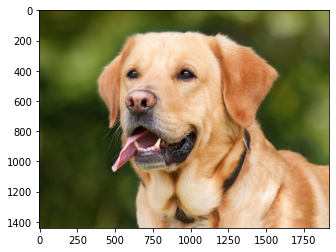

In [ ]:
from PIL import Image

urllib.request.urlretrieve("https://3c1703fe8d.site.internapcdn.net/newman/gfx/news/hires/2018/2-dog.jpg", "dog_image.jpg")
%ls

pil_image = Image.open("dog_image.jpg")
show_image(pil_image)


As you know, when the network was trained, ImageNet images went through some preprocessing transformations. Before feeding an image to the network, we should do the same transformations. 

As in validation, we will:
* Resize our image to size 256 (this means, the smallest side will be 256)
* Cropping the image at the center with size 224
* Converting our image to a torch tensor 
* Normalizing the values of the pixels with Imagenet mean and standard deviation for each channel. These are values are: `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`

We will use `transforms.Compose` to compose all these transformations in a single method.

### Exercise 6

Define the preprocessing transformations.

In [ ]:
preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize
        ])

torch_image = preprocess(pil_image)
try:
    assert isinstance(torch_image, torch.Tensor)
    assert list(torch_image.shape) == [3, 224, 224]
    print("Well done!")
except Exception:
    raise Exception("Did you do the 4 required transformations?")
    

Well done!


We can take a look at the image that will go through the network.

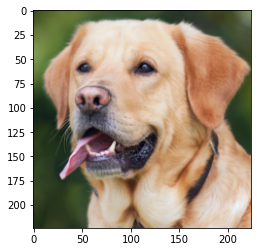

In [ ]:
from torchvision.transforms.functional import to_pil_image
def show_torch_image(torch_image):
    img = (torch_image-torch_image.min()) / (torch_image.max() - torch_image.min())
    show_image(to_pil_image(img))
show_torch_image(torch_image)

Now we can get the predictions of our network. Note that our model expects a batch dimension at the beginning, so we should add it with the method `.unsqueeze()`.

### Exercise 7
Complete the predict function. Remember to move the images to GPU, as well as adding the batch dimension.

In [ ]:
def predict_image(torch_image, model, topk=3):
    x = torch_image.to(device)
    x = x.unsqueeze(0)
    output = model(x)
    output = torch.softmax(output, dim=1)  # Compute the softmax to get probabilities
    probs, idxs = output.topk(topk)  # Get the top 3 predicitons
    return [(labels[i.item()], p.item()*100) for p, i in zip(probs[0], idxs[0])]

print(predict_image(torch_image, model))

[('Labrador retriever', 72.36018776893616), ('golden retriever', 24.120163917541504), ('Rhodesian ridgeback', 0.9159100241959095)]


### Exercise 8
Do the prediction with other images using different networks and compare the results.  You can use the function following function predict_from_url. The list of pretrained PyTorch networks can be found here https://pytorch.org/docs/stable/torchvision/models.html. When trying different models remember to move them to GPU and set evaluation mode.

[('tabby, tabby cat', 48.55090081691742), ('tiger cat', 36.320799589157104), ('Egyptian cat', 12.879610061645508)]


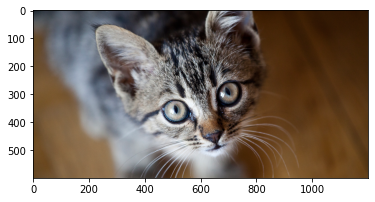

In [ ]:
def predict_from_url(url, model):
    urllib.request.urlretrieve(url, "image.jpg")
    pil_image = Image.open("image.jpg")
    show_image(pil_image)
    torch_image = preprocess(pil_image)
    print(predict_image(torch_image, model))

predict_from_url("https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png", model)